<a href="https://colab.research.google.com/github/merylmizell/ResNetForCTScans/blob/main/TrainingResNet152V3_Optimized7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/664.8 MB 109.7 MB/s eta 0:00:06ERROR: Operation cancelled by user
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/664.8 MB 109.7 MB/s eta 0:00:06


In [ ]:
pip install tensorflow

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from google.colab import drive
import logging
from tqdm import tqdm

# Custom dataset class
class HemorrhageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row["png_path"]).convert("RGB")
        image = self.transform(image)
        labels = torch.tensor(row.iloc[1:-1].values, dtype=torch.float32)
        return image, labels

In [2]:
# Define the file paths
csv_files = ["train.csv", "val.csv", "test.csv"]  # Add or remove CSV files as needed
old_path = "C:\\Users\\Myers\\Desktop\\rsna-ihd-dataset_extracted\\rsna-intracranial-hemorrhage-detection\\preprocessed_images\\"
new_path = "/content/drive/MyDrive/preprocessed_images5K/"

for csv_file in csv_files:
    # Load the CSV
    df = pd.read_csv(csv_file)

    # Replace the file paths in the 'png_path' column
    df["png_path"] = df["png_path"].str.replace(old_path, new_path, regex=False)

    # Save the updated CSV file (overwrite or create a new file)
    updated_csv_file = f"updated_{csv_file}"  # Saves as 'updated_train.csv', etc.
    df.to_csv(updated_csv_file, index=False)

    print(f"Updated file saved as: {updated_csv_file}")


Updated file saved as: updated_train.csv
Updated file saved as: updated_val.csv
Updated file saved as: updated_test.csv


In [3]:
# Load data
train_df = pd.read_csv("/content/updated_test.csv")  # Update path
val_df = pd.read_csv("/content/updated_val.csv")
test_df = pd.read_csv("/content/updated_test.csv")

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [5]:
# prompt: head of both df

print(train_df.head())
print(val_df.head())
print(test_df.head())


       dicom_id  subdural  epidural  subarachnoid  intraparenchymal  \
0  ID_01241a0ab       0.0       0.0           0.0               0.0   
1  ID_042ab92ef       0.0       0.0           0.0               0.0   
2  ID_03678fae1       0.0       0.0           0.0               0.0   
3  ID_01ed2b6c3       0.0       0.0           0.0               0.0   
4  ID_04e8cccc0       0.0       0.0           0.0               0.0   

   intraventricular  any  none  \
0               0.0  0.0     1   
1               0.0  0.0     1   
2               0.0  0.0     1   
3               0.0  0.0     1   
4               0.0  0.0     1   

                                            png_path  
0  /content/drive/MyDrive/preprocessed_images5K/I...  
1  /content/drive/MyDrive/preprocessed_images5K/I...  
2  /content/drive/MyDrive/preprocessed_images5K/I...  
3  /content/drive/MyDrive/preprocessed_images5K/I...  
4  /content/drive/MyDrive/preprocessed_images5K/I...  
       dicom_id  subdural  epidural  s

In [6]:
class HemorrhageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["png_path"]

        # Load grayscale image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = self.transform(image)

        # Extract labels and handle potential non-numeric values
        labels = row.iloc[1:-1]  # Exclude dicom_id and png_path
        labels = labels.apply(pd.to_numeric, errors='coerce').fillna(0)  # Convert to numeric, replace NaNs with 0
        labels = np.array(labels, dtype=np.float32)  # Convert to float32 NumPy array
        labels = torch.tensor(labels, dtype=torch.float32)  # Convert to PyTorch tensor

        return image, labels

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Define the correct label columns
label_columns = ['subdural', 'epidural', 'subarachnoid', 'intraparenchymal', 'intraventricular', 'any', 'none']

# Compute label counts
label_counts = train_df[label_columns].sum()
total_samples = len(train_df)

# Calculate pos_weight: inverse of frequency
pos_weights = (total_samples - label_counts) / label_counts
pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

print("Computed pos_weights:", pos_weights)


Computed pos_weights: tensor([ 11.5000, 186.5000,  20.4286,  19.8333,  24.0000,   4.9524,   0.2019],
       device='cuda:0')


In [9]:
# Create dataset and dataloader
train_dataset = HemorrhageDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset & DataLoader
val_dataset = HemorrhageDataset(val_df)  # Assuming val_df contains validation data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Define val_loader

# Create the validation dataset & DataLoader
test_dataset = HemorrhageDataset(test_df)  # Assuming val_df contains validation data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Define val_loader

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Display sample batch
sample_images, sample_labels = next(iter(train_loader))
print("Sample Batch Shape:", sample_images.shape, sample_labels.shape)


Sample Batch Shape: torch.Size([32, 1, 224, 224]) torch.Size([32, 7])


In [12]:
# Load pre-trained ResNet-151 model
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 120MB/s]


In [13]:
# Modify the first layer to accept 1-channel grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [14]:
# Modify the last layer to match the number of labels (7 output classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes for hemorrhage types


In [15]:
# Move model to GPU (if available)
model = model.to(device)

In [16]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Use BCE for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#trying a more aggressive decay for more epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [18]:
def validate(model, val_loader, criterion, best_thresholds=None):
    model.eval()
    val_loss = 0
    total_correct = [0] * 7
    total_counts = [0] * 7

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)

            # Apply per-label thresholds if provided, else default to 0.5
            if best_thresholds is not None:
                binary_preds = torch.zeros_like(probs)
                for i, t in enumerate(best_thresholds):
                    binary_preds[:, i] = (probs[:, i] > t).float()
            else:
                binary_preds = (probs > 0.5).float()

            # Accumulate accuracy
            for i in range(7):
                total_correct[i] += (binary_preds[:, i] == labels[:, i]).sum().item()
                total_counts[i] += labels.size(0)

            all_preds.append(binary_preds.cpu())
            all_targets.append(labels.cpu())

    val_loss /= len(val_loader)
    class_accuracies = [100 * c / t if t != 0 else 0 for c, t in zip(total_correct, total_counts)]

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return val_loss, class_accuracies, all_preds, all_targets


In [19]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [20]:
def optimize_thresholds(model, val_loader, criterion, thresholds=np.arange(0.1, 0.9, 0.1), label_names=None):
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            all_outputs.append(torch.sigmoid(outputs).cpu())
            all_targets.append(labels.cpu())

    all_outputs = torch.cat(all_outputs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    best_thresholds = []
    best_f1s = []

    print("\n🔎 Optimizing thresholds...\n")
    for class_idx in range(all_outputs.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for t in thresholds:
            preds = (all_outputs[:, class_idx] > t).astype(int)
            f1 = f1_score(all_targets[:, class_idx], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t

        best_thresholds.append(best_thresh)
        best_f1s.append(best_f1)
        label = label_names[class_idx] if label_names else f"Class {class_idx}"
        print(f"{label:<20} | Best Threshold: {best_thresh:.2f} | F1-score: {best_f1:.3f}")

    return best_thresholds, best_f1s


In [21]:

import json

num_epochs = 16
best_val_loss = float("inf")
best_avg_f1 = 0  # Track best average F1 across all labels

for epoch in range(num_epochs):
    print(f"\n🔁 Starting Epoch {epoch + 1}/{num_epochs}...")
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 10 == 0:
            log_msg = f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}"
            logging.info(log_msg)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)

    label_names = ['subdural', 'epidural', 'subarachnoid', 'intraparenchymal',
                   'intraventricular', 'any', 'none']

    # Run validation
    val_loss, class_accuracies, preds, targets = validate(model, val_loader, criterion)

    print(f"\n📉 Validation Loss: {val_loss:.4f}")
    for name, acc in zip(label_names, class_accuracies):
        print(f"{name} Accuracy: {acc:.2f}%")

    print("\n🧮 Classification Report (threshold = 0.5):")
    print(classification_report(targets, preds, target_names=label_names, zero_division=0))

    # Optimize thresholds and evaluate F1
    best_thresholds, best_f1s = optimize_thresholds(model, val_loader, criterion, label_names=label_names)

    print("\n🎯 Best per-label thresholds this epoch:")
    for name, thresh, f1 in zip(label_names, best_thresholds, best_f1s):
        print(f"{name:<20} | Threshold: {thresh:.2f} | F1: {f1:.3f}")

    avg_f1 = np.mean(best_f1s)

    # Save best thresholds if F1 improves
    if avg_f1 > best_avg_f1:
        best_avg_f1 = avg_f1
        with open("best_thresholds.json", "w") as f:
            json.dump({name: float(t) for name, t in zip(label_names, best_thresholds)}, f)
        print(f"\n💾 New best F1 avg: {avg_f1:.3f} — thresholds saved!")

    # Log and optionally save model
    log_msg = f"✅ Epoch {epoch + 1} done — Avg Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {np.mean(class_accuracies):.2f}%"
    logging.info(log_msg)
    print(log_msg)

    if val_loss < best_val_loss:
        logging.info(f"📈 Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resnet101.pth")



🔁 Starting Epoch 1/20...



📉 Validation Loss: 67.6630
subdural Accuracy: 7.87%
epidural Accuracy: 3.47%
subarachnoid Accuracy: 95.33%
intraparenchymal Accuracy: 5.87%
intraventricular Accuracy: 95.33%
any Accuracy: 16.93%
none Accuracy: 16.40%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.07      1.00      0.13        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.00      0.00      0.00        35
intraparenchymal       0.06      1.00      0.11        44
intraventricular       0.00      0.00      0.00        35
             any       0.16      1.00      0.28       123
            none       0.00      0.00      0.00       627

       micro avg       0.07      0.24      0.11       918
       macro avg       0.04      0.57      0.08       918
    weighted avg       0.03      0.24      0.05       918
     samples avg       0.07      0.13      0.09       918


🔎 Optimizing thresholds...

subdural  


📉 Validation Loss: 5.3216
subdural Accuracy: 63.07%
epidural Accuracy: 0.53%
subarachnoid Accuracy: 42.40%
intraparenchymal Accuracy: 41.73%
intraventricular Accuracy: 42.00%
any Accuracy: 55.07%
none Accuracy: 83.60%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.03      0.16      0.05        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.06      0.74      0.11        35
intraparenchymal       0.08      0.82      0.14        44
intraventricular       0.07      0.94      0.13        35
             any       0.24      0.79      0.37       123
            none       0.84      1.00      0.91       627

       micro avg       0.24      0.91      0.37       918
       macro avg       0.19      0.78      0.25       918
    weighted avg       0.61      0.91      0.69       918
     samples avg       0.26      0.95      0.39       918


🔎 Optimizing thresholds...

subdural 


📉 Validation Loss: 1.2843
subdural Accuracy: 22.67%
epidural Accuracy: 0.53%
subarachnoid Accuracy: 4.67%
intraparenchymal Accuracy: 73.07%
intraventricular Accuracy: 16.40%
any Accuracy: 27.20%
none Accuracy: 26.80%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.08      0.98      0.14        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.05      1.00      0.09        35
intraparenchymal       0.13      0.66      0.22        44
intraventricular       0.05      1.00      0.10        35
             any       0.18      0.99      0.31       123
            none       1.00      0.12      0.22       627

       micro avg       0.09      0.38      0.15       918
       macro avg       0.21      0.82      0.16       918
    weighted avg       0.72      0.38      0.22       918
     samples avg       0.10      0.26      0.14       918


🔎 Optimizing thresholds...

subdural  


📉 Validation Loss: 1.1590
subdural Accuracy: 6.67%
epidural Accuracy: 0.53%
subarachnoid Accuracy: 7.60%
intraparenchymal Accuracy: 5.87%
intraventricular Accuracy: 4.67%
any Accuracy: 16.40%
none Accuracy: 16.40%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.07      1.00      0.12        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.05      1.00      0.09        35
intraparenchymal       0.06      1.00      0.11        44
intraventricular       0.05      1.00      0.09        35
             any       0.16      1.00      0.28       123
            none       0.00      0.00      0.00       627

       micro avg       0.06      0.32      0.11       918
       macro avg       0.06      0.86      0.10       918
    weighted avg       0.03      0.32      0.06       918
     samples avg       0.06      0.16      0.09       918


🔎 Optimizing thresholds...

subdural     


📉 Validation Loss: 1.1070
subdural Accuracy: 22.40%
epidural Accuracy: 22.93%
subarachnoid Accuracy: 16.27%
intraparenchymal Accuracy: 27.33%
intraventricular Accuracy: 24.53%
any Accuracy: 36.40%
none Accuracy: 35.07%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.08      0.96      0.14        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.05      0.97      0.10        35
intraparenchymal       0.07      0.98      0.14        44
intraventricular       0.06      1.00      0.11        35
             any       0.20      0.96      0.33       123
            none       0.97      0.23      0.37       627

       micro avg       0.11      0.47      0.18       918
       macro avg       0.20      0.87      0.17       918
    weighted avg       0.70      0.47      0.32       918
     samples avg       0.21      0.35      0.25       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.1019
subdural Accuracy: 19.47%
epidural Accuracy: 28.93%
subarachnoid Accuracy: 26.67%
intraparenchymal Accuracy: 32.80%
intraventricular Accuracy: 29.60%
any Accuracy: 36.80%
none Accuracy: 34.93%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.07      0.94      0.13        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.06      0.94      0.11        35
intraparenchymal       0.08      0.98      0.15        44
intraventricular       0.06      0.91      0.11        35
             any       0.20      0.95      0.33       123
            none       0.95      0.23      0.37       627

       micro avg       0.12      0.46      0.19       918
       macro avg       0.20      0.85      0.17       918
    weighted avg       0.69      0.46      0.32       918
     samples avg       0.22      0.35      0.26       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 2.1128
subdural Accuracy: 70.80%
epidural Accuracy: 65.87%
subarachnoid Accuracy: 53.20%
intraparenchymal Accuracy: 75.20%
intraventricular Accuracy: 67.60%
any Accuracy: 70.67%
none Accuracy: 63.73%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.10      0.44      0.17        50
        epidural       0.01      0.75      0.02         4
    subarachnoid       0.06      0.66      0.12        35
intraparenchymal       0.11      0.43      0.17        44
intraventricular       0.08      0.57      0.14        35
             any       0.28      0.49      0.35       123
            none       0.87      0.67      0.75       627

       micro avg       0.29      0.62      0.39       918
       macro avg       0.22      0.57      0.25       918
    weighted avg       0.65      0.62      0.59       918
     samples avg       0.54      0.64      0.57       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0043
subdural Accuracy: 58.67%
epidural Accuracy: 32.67%
subarachnoid Accuracy: 56.80%
intraparenchymal Accuracy: 59.73%
intraventricular Accuracy: 54.67%
any Accuracy: 66.00%
none Accuracy: 62.27%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.80      0.21        50
        epidural       0.01      1.00      0.02         4
    subarachnoid       0.09      0.86      0.16        35
intraparenchymal       0.12      0.93      0.21        44
intraventricular       0.09      0.91      0.16        35
             any       0.31      0.85      0.45       123
            none       0.96      0.57      0.72       627

       micro avg       0.23      0.67      0.35       918
       macro avg       0.24      0.85      0.27       918
    weighted avg       0.71      0.67      0.58       918
     samples avg       0.45      0.62      0.50       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0533
subdural Accuracy: 66.13%
epidural Accuracy: 46.40%
subarachnoid Accuracy: 43.73%
intraparenchymal Accuracy: 72.00%
intraventricular Accuracy: 58.53%
any Accuracy: 69.33%
none Accuracy: 65.33%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.11      0.56      0.18        50
        epidural       0.01      1.00      0.02         4
    subarachnoid       0.07      0.86      0.12        35
intraparenchymal       0.15      0.84      0.26        44
intraventricular       0.09      0.91      0.17        35
             any       0.32      0.77      0.45       123
            none       0.94      0.63      0.75       627

       micro avg       0.26      0.67      0.37       918
       macro avg       0.24      0.80      0.28       918
    weighted avg       0.70      0.67      0.61       918
     samples avg       0.45      0.65      0.51       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0308
subdural Accuracy: 86.80%
epidural Accuracy: 80.53%
subarachnoid Accuracy: 86.53%
intraparenchymal Accuracy: 89.73%
intraventricular Accuracy: 88.80%
any Accuracy: 85.60%
none Accuracy: 85.73%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.20      0.32      0.24        50
        epidural       0.02      0.75      0.04         4
    subarachnoid       0.19      0.57      0.28        35
intraparenchymal       0.26      0.41      0.32        44
intraventricular       0.22      0.57      0.32        35
             any       0.58      0.44      0.50       123
            none       0.90      0.93      0.92       627

       micro avg       0.58      0.78      0.66       918
       macro avg       0.34      0.57      0.37       918
    weighted avg       0.73      0.78      0.74       918
     samples avg       0.79      0.85      0.81       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.7714
subdural Accuracy: 35.47%
epidural Accuracy: 34.27%
subarachnoid Accuracy: 32.80%
intraparenchymal Accuracy: 38.67%
intraventricular Accuracy: 37.20%
any Accuracy: 42.80%
none Accuracy: 42.53%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.09      0.98      0.17        50
        epidural       0.01      1.00      0.02         4
    subarachnoid       0.06      0.94      0.12        35
intraparenchymal       0.08      0.95      0.15        44
intraventricular       0.07      0.97      0.13        35
             any       0.22      0.97      0.36       123
            none       0.98      0.32      0.48       627

       micro avg       0.15      0.52      0.23       918
       macro avg       0.22      0.88      0.20       918
    weighted avg       0.71      0.52      0.40       918
     samples avg       0.32      0.42      0.35       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0816
subdural Accuracy: 35.60%
epidural Accuracy: 21.33%
subarachnoid Accuracy: 37.07%
intraparenchymal Accuracy: 45.60%
intraventricular Accuracy: 41.07%
any Accuracy: 40.27%
none Accuracy: 39.47%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.09      0.90      0.16        50
        epidural       0.01      1.00      0.01         4
    subarachnoid       0.06      0.89      0.12        35
intraparenchymal       0.09      0.91      0.16        44
intraventricular       0.07      0.89      0.12        35
             any       0.20      0.91      0.33       123
            none       0.94      0.29      0.45       627

       micro avg       0.14      0.49      0.21       918
       macro avg       0.21      0.83      0.19       918
    weighted avg       0.69      0.49      0.38       918
     samples avg       0.23      0.39      0.28       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0891
subdural Accuracy: 72.93%
epidural Accuracy: 68.93%
subarachnoid Accuracy: 75.07%
intraparenchymal Accuracy: 77.47%
intraventricular Accuracy: 77.47%
any Accuracy: 72.80%
none Accuracy: 72.53%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.54      0.21        50
        epidural       0.01      0.50      0.02         4
    subarachnoid       0.09      0.46      0.15        35
intraparenchymal       0.13      0.52      0.21        44
intraventricular       0.13      0.69      0.22        35
             any       0.32      0.59      0.41       123
            none       0.90      0.75      0.82       627

       micro avg       0.37      0.69      0.48       918
       macro avg       0.25      0.58      0.29       918
    weighted avg       0.68      0.69      0.65       918
     samples avg       0.62      0.72      0.65       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0417
subdural Accuracy: 87.73%
epidural Accuracy: 84.93%
subarachnoid Accuracy: 92.00%
intraparenchymal Accuracy: 91.87%
intraventricular Accuracy: 93.33%
any Accuracy: 86.93%
none Accuracy: 86.93%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.22      0.34      0.27        50
        epidural       0.03      0.75      0.05         4
    subarachnoid       0.24      0.34      0.29        35
intraparenchymal       0.30      0.30      0.30        44
intraventricular       0.33      0.43      0.38        35
             any       0.68      0.38      0.49       123
            none       0.89      0.96      0.93       627

       micro avg       0.66      0.78      0.71       918
       macro avg       0.39      0.50      0.38       918
    weighted avg       0.75      0.78      0.75       918
     samples avg       0.81      0.86      0.82       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.8644
subdural Accuracy: 60.53%
epidural Accuracy: 47.20%
subarachnoid Accuracy: 64.40%
intraparenchymal Accuracy: 66.27%
intraventricular Accuracy: 66.13%
any Accuracy: 66.93%
none Accuracy: 66.40%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.86      0.23        50
        epidural       0.01      1.00      0.02         4
    subarachnoid       0.11      0.91      0.19        35
intraparenchymal       0.14      0.93      0.24        44
intraventricular       0.11      0.89      0.20        35
             any       0.32      0.90      0.47       123
            none       0.97      0.62      0.75       627

       micro avg       0.28      0.71      0.40       918
       macro avg       0.26      0.87      0.30       918
    weighted avg       0.73      0.71      0.62       918
     samples avg       0.52      0.66      0.56       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.8997
subdural Accuracy: 83.33%
epidural Accuracy: 74.13%
subarachnoid Accuracy: 87.73%
intraparenchymal Accuracy: 90.93%
intraventricular Accuracy: 90.13%
any Accuracy: 85.33%
none Accuracy: 86.00%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.18      0.44      0.26        50
        epidural       0.02      1.00      0.04         4
    subarachnoid       0.16      0.40      0.23        35
intraparenchymal       0.35      0.66      0.46        44
intraventricular       0.27      0.63      0.37        35
             any       0.55      0.54      0.55       123
            none       0.91      0.92      0.92       627

       micro avg       0.56      0.80      0.66       918
       macro avg       0.35      0.66      0.40       918
    weighted avg       0.74      0.80      0.76       918
     samples avg       0.76      0.85      0.79       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.8825
subdural Accuracy: 77.33%
epidural Accuracy: 54.80%
subarachnoid Accuracy: 80.27%
intraparenchymal Accuracy: 83.60%
intraventricular Accuracy: 85.60%
any Accuracy: 81.07%
none Accuracy: 80.93%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.16      0.58      0.25        50
        epidural       0.01      0.75      0.02         4
    subarachnoid       0.14      0.63      0.23        35
intraparenchymal       0.23      0.77      0.36        44
intraventricular       0.21      0.74      0.33        35
             any       0.45      0.70      0.55       123
            none       0.93      0.83      0.88       627

       micro avg       0.42      0.79      0.55       918
       macro avg       0.30      0.72      0.37       918
    weighted avg       0.73      0.79      0.73       918
     samples avg       0.64      0.80      0.69       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.8100
subdural Accuracy: 72.27%
epidural Accuracy: 60.53%
subarachnoid Accuracy: 75.60%
intraparenchymal Accuracy: 77.47%
intraventricular Accuracy: 79.07%
any Accuracy: 78.80%
none Accuracy: 78.80%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.16      0.74      0.26        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.14      0.80      0.23        35
intraparenchymal       0.20      0.91      0.32        44
intraventricular       0.16      0.86      0.28        35
             any       0.43      0.84      0.56       123
            none       0.96      0.78      0.86       627

       micro avg       0.39      0.80      0.52       918
       macro avg       0.29      0.85      0.36       918
    weighted avg       0.74      0.80      0.71       918
     samples avg       0.65      0.78      0.69       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.8965
subdural Accuracy: 77.33%
epidural Accuracy: 62.00%
subarachnoid Accuracy: 83.47%
intraparenchymal Accuracy: 84.93%
intraventricular Accuracy: 86.67%
any Accuracy: 81.07%
none Accuracy: 80.80%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.16      0.54      0.24        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.16      0.60      0.25        35
intraparenchymal       0.23      0.66      0.34        44
intraventricular       0.21      0.69      0.32        35
             any       0.45      0.67      0.54       123
            none       0.93      0.84      0.88       627

       micro avg       0.45      0.78      0.57       918
       macro avg       0.31      0.71      0.37       918
    weighted avg       0.73      0.78      0.72       918
     samples avg       0.67      0.80      0.71       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9469
subdural Accuracy: 77.47%
epidural Accuracy: 66.53%
subarachnoid Accuracy: 80.53%
intraparenchymal Accuracy: 85.60%
intraventricular Accuracy: 88.00%
any Accuracy: 79.47%
none Accuracy: 79.33%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.15      0.50      0.23        50
        epidural       0.01      0.50      0.02         4
    subarachnoid       0.13      0.54      0.21        35
intraparenchymal       0.26      0.80      0.39        44
intraventricular       0.23      0.66      0.34        35
             any       0.42      0.65      0.51       123
            none       0.92      0.82      0.87       627

       micro avg       0.45      0.76      0.57       918
       macro avg       0.30      0.64      0.37       918
    weighted avg       0.72      0.76      0.71       918
     samples avg       0.67      0.79      0.71       918


🔎 Optimizing thresholds...

subdural

In [22]:
#just double checking
print(f"Total training images: {len(train_dataset)}")
print(f"Expected number of images: {len(train_df)}")  # Should match 750

sample_images, sample_labels = next(iter(train_loader))

print(f"Image Batch Shape: {sample_images.shape}")  # Should be [batch_size, channels, 224, 224]
print(f"Label Batch Shape: {sample_labels.shape}")  # Should be [batch_size, num_classes]


Total training images: 750
Expected number of images: 750
Image Batch Shape: torch.Size([32, 1, 224, 224])
Label Batch Shape: torch.Size([32, 7])


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet model
model = models.resnet101(pretrained=False)  # Load model without pretrained weights
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for grayscale input
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # Assuming 7 output labels
model = model.to(device)

# Load best trained weights
model.load_state_dict(torch.load("best_resnet101.pth"))
model.eval()  # Set to evaluation mode


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# Load thresholds first
import json

label_names = ['subdural', 'epidural', 'subarachnoid', 'intraparenchymal',
               'intraventricular', 'any', 'none']

with open("best_thresholds.json", "r") as f:
    threshold_dict = json.load(f)

best_thresholds = [threshold_dict[label] for label in label_names]

# Now validate on the test set
test_loss, test_accuracies, test_preds, test_targets = validate(
    model, test_loader, criterion, best_thresholds=best_thresholds
)

print(f"\n✅ Test Loss: {test_loss:.4f}, Mean Accuracy: {np.mean(test_accuracies):.2f}%")

# Optional: Full classification report
from sklearn.metrics import classification_report
print("\n📊 Classification Report:")
print(classification_report(test_targets, test_preds, target_names=label_names, zero_division=0))


✅ Test Loss: 0.6988, Mean Accuracy: 82.84%

📊 Classification Report:
                  precision    recall  f1-score   support

        subdural       0.25      0.52      0.34        60
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.22      0.63      0.33        35
intraparenchymal       0.21      0.89      0.35        36
intraventricular       0.28      0.73      0.41        30
             any       0.52      0.79      0.63       126
            none       0.91      0.93      0.92       624

       micro avg       0.50      0.87      0.64       915
       macro avg       0.35      0.78      0.43       915
    weighted avg       0.74      0.87      0.78       915
     samples avg       0.71      0.89      0.76       915



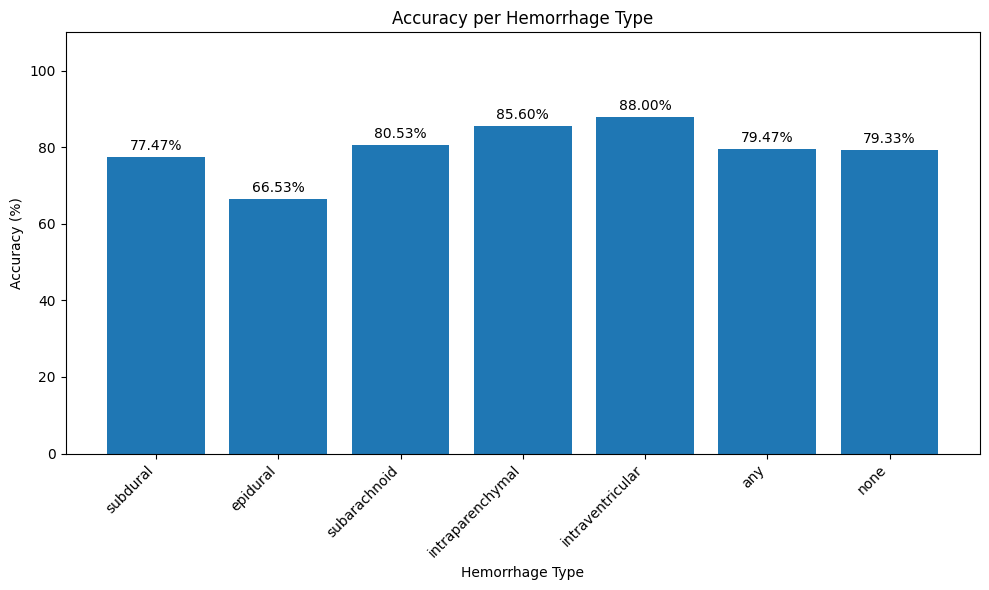

In [29]:
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, class_accuracies) # Store the bar objects
plt.xlabel("Hemorrhage Type")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Hemorrhage Type")
plt.ylim(0, 100 + 10)  # Add extra space for text above bars
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add percentage text above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()
